In [27]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import requests
import time
from time import gmtime, strftime
from scipy.stats import linregress
import json
from pprint import pprint
import csv
import chart_studio.plotly as py
import plotly.express as px
import panel as pn
import hvplot.pandas  # noqa

# Reading Netflix file
netflix_titles_path = "Output/TMDB_OMDB.CSV"

# Read the mouse data and the study results
netflix_titles_temp = pd.read_csv(netflix_titles_path)
netflix_titles_temp.replace('', np.nan, inplace=True) 
fill_values = {'Movie ID':0,'director': 'Director Not Available', 'Cast': 'Cast Not Available', 'country': 'Country Not Available', 'listed_in': 'Catagory not available'}
netflix_titles_temp.fillna(value=fill_values, inplace=True)
netflix_titles_temp.drop(columns=["Unnamed: 0","Unnamed: 0.1"],inplace=True)
netflix_titles = netflix_titles_temp.loc[netflix_titles_temp['Movie ID'] != 0, :]
netflix_titles.head()

,show_id,type,title,director,cast,country,date_added,Netflix release year,rating,duration,...,description,IMDB rating,Rotten Tomatoes rating,Award,Released Date,IMDB rating group,Title,Budget,Movie ID,Revenue
2,80163890,TV Show,Apaches,Director Not Available,"Alberto Ammann, Eloy Azorín, Verónica Echegui,...",Spain,"September 8, 2017",2016,TV-MA,1 Season,...,A young journalist is forced into a life of cr...,5.0,31.0,2 nominations.,14 Aug 2013,5%,Apaches,0,164337.0,0
3,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,...,"In a dystopian future, an insurance adjuster f...",6.0,29.0,6 nominations.,17 Oct 2014,6%,Automata,7000000,262543.0,0
5,70304990,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden","September 8, 2017",2014,R,90 min,...,A struggling couple can't believe their luck w...,5.0,12.0,NaN,21 Aug 2015,5%,Good People,0,262338.0,0
6,80169755,Movie,Joaquín Reyes: Una y no más,José Miguel Contreras,Joaquín Reyes,Country Not Available,"September 8, 2017",2017,TV-MA,78 min,...,Comedian and celebrity impersonator Joaquín Re...,0.0,0.0,NaN,NaN,NaN,Joaquín Reyes: Una y no más,0,474599.0,0
7,70299204,Movie,Kidnapping Mr. Heineken,Daniel Alfredson,"Jim Sturgess, Sam Worthington, Ryan Kwanten, A...","Netherlands, Belgium, United Kingdom, United S...","September 8, 2017",2015,R,95 min,...,"When beer magnate Alfred ""Freddy"" Heineken is ...",6.0,19.0,NaN,06 Mar 2015,6%,Kidnapping Mr. Heineken,0,228968.0,2633527


In [28]:
netflix_titles_countries = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "Country": netflix_titles["country"]}) 
netflix_titles_listed_in = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "ListedIn": netflix_titles["listed_in"]})
netflix_titles_directors = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "Director": netflix_titles["director"]})
netflix_titles_casts = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "Cast": netflix_titles["cast"]})

In [29]:
netflix_titles_countries.Country = netflix_titles_countries.Country.str.split(', ')
netflix_titles_listed_in.ListedIn = netflix_titles_listed_in.ListedIn.str.split(', ')
netflix_titles_directors.Director = netflix_titles_directors.Director.str.split(', ')
netflix_titles_casts.Cast = netflix_titles_casts.Cast.str.split(', ')

In [30]:
netflix_titles_countries = netflix_titles_countries.explode('Country').reset_index(drop=True)
netflix_titles_listed_in = netflix_titles_listed_in.explode('ListedIn').reset_index(drop=True)
netflix_titles_directors = netflix_titles_directors.explode('Director').reset_index(drop=True)
netflix_titles_casts = netflix_titles_casts.explode('Cast').reset_index(drop=True)

In [31]:
netflix_titles_countries.head (30)

,Titles,Country
0,80163890,Spain
1,70304989,Bulgaria
2,70304989,United States
3,70304989,Spain
4,70304989,Canada
5,70304990,United States
6,70304990,United Kingdom
7,70304990,Denmark
8,70304990,Sweden
9,80169755,Country Not Available


In [32]:
netflix_titles_listed_in.head (30)

,Titles,ListedIn
0,80163890,Crime TV Shows
1,80163890,International TV Shows
2,80163890,Spanish-Language TV Shows
3,70304989,International Movies
4,70304989,Sci-Fi & Fantasy
5,70304989,Thrillers
6,70304990,Action & Adventure
7,70304990,Thrillers
8,80169755,Stand-Up Comedy
9,70299204,Action & Adventure


In [33]:
netflix_titles_directors.head(30)

,Titles,Director
0,80163890,Director Not Available
1,70304989,Gabe Ibáñez
2,70304990,Henrik Ruben Genz
3,80169755,José Miguel Contreras
4,70299204,Daniel Alfredson
5,80060297,Tom O'Brien
6,80046728,Antoine Bardou-Jacquet
7,80046727,Mitch Dickman
8,70304988,Brad Anderson
9,80057700,Austin Stark


In [34]:
netflix_titles_casts.head(30)

,Titles,Cast
0,80163890,Alberto Ammann
1,80163890,Eloy Azorín
2,80163890,Verónica Echegui
3,80163890,Lucía Jiménez
4,80163890,Claudia Traisac
5,70304989,Antonio Banderas
6,70304989,Dylan McDermott
7,70304989,Melanie Griffith
8,70304989,Birgitte Hjort Sørensen
9,70304989,Robert Forster


## 	Graph of the countries that contribute producing movies for NetFlix

In [35]:
Countries_path = 'data\countries.csv'
lats, lons = [], []

Countries = pd.read_csv(Countries_path)
lats = [float(i) for i in Countries.latitude.tolist()]
lons = [float(i) for i in Countries.longitude.tolist()]
Countries.head()

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [36]:
netflix_titles_countries_count = netflix_titles_countries.groupby("Country").count()

netflix_titles_countries_count.head()
netflix_titles_countries_count_merged_position = netflix_titles_countries_count.merge (Countries, left_on='Country', right_on='name')
netflix_titles_countries_count_merged_names = netflix_titles_countries_count_merged_position.name.tolist()

In [37]:
list1 = netflix_titles_countries_count.Titles.tolist()
"""
m = interp1d ([1,max(list1)],[1,20])
circle_radius = m(list1)

bins = [0, 199999, 399999, 599999, 799999, 999999,
        1999999, 2999999, 3999999, 4999999, 50000000]
print(sorted(list1))
"""
list2 = []

#list2 = [int(j) / max(list1[i]) for j,i in zip(list1, range(len(list1)))]

#list2.remove(max_value)

for i in range(len(list1)):
    if list1[i] / 17 < 1:
        list2.append (1)
    elif list1[i] == max (list1):
            list2.append (20)
    elif list1[i] >150 :
        list2.append (15)
    else:
        list2.append(int (list1[i] / 17))
    
list3 = [float(i)/max(list1) for i in list1]

"""print (circle_radius)
print ('----------------')
print (list2)"""
typelist = ['open-street-map','white-bg','carto-positron','carto-darkmatter','stamen-terrain','stamen-watercolor','satellite-streets']

"""for i in typelist:
        print (i)
        fig = px.density_mapbox (netflix_titles_countries_count_merged_position, lat='latitude', lon='longitude', radius=circle_radius,
                                zoom=1, mapbox_style=i)
        fig.show ()"""

In [38]:
fig = px.density_mapbox (netflix_titles_countries_count_merged_position, lat='latitude', lon='longitude', radius=list2,
                                zoom=0.5, mapbox_style='carto-positron', hover_data=['name','Titles'])
fig.show ()

In [39]:
netflix_genre_countries = netflix_titles_listed_in.merge (netflix_titles_countries, left_on='Titles',right_on='Titles')
netflix_genre_countries.head()

,Titles,ListedIn,Country
0,80163890,Crime TV Shows,Spain
1,80163890,International TV Shows,Spain
2,80163890,Spanish-Language TV Shows,Spain
3,70304989,International Movies,Bulgaria
4,70304989,International Movies,United States


In [40]:
net_flix = pd.DataFrame(netflix_genre_countries.groupby(["ListedIn","Country"])['ListedIn'].count())

In [41]:
net_flix.rename (columns={'ListedIn':'Genre'}, inplace = True)

In [42]:
netflix_groupby_genre_countries = netflix_genre_countries.groupby('ListedIn').count()
netflix_groupby_genre_countries.head()

,Titles,Country
ListedIn,,
Action & Adventure,761,761
Anime Features,16,16
Anime Series,18,18
British TV Shows,76,76
Children & Family Movies,437,437


## Number of Titles Produced by Countries for each Content Type (All)

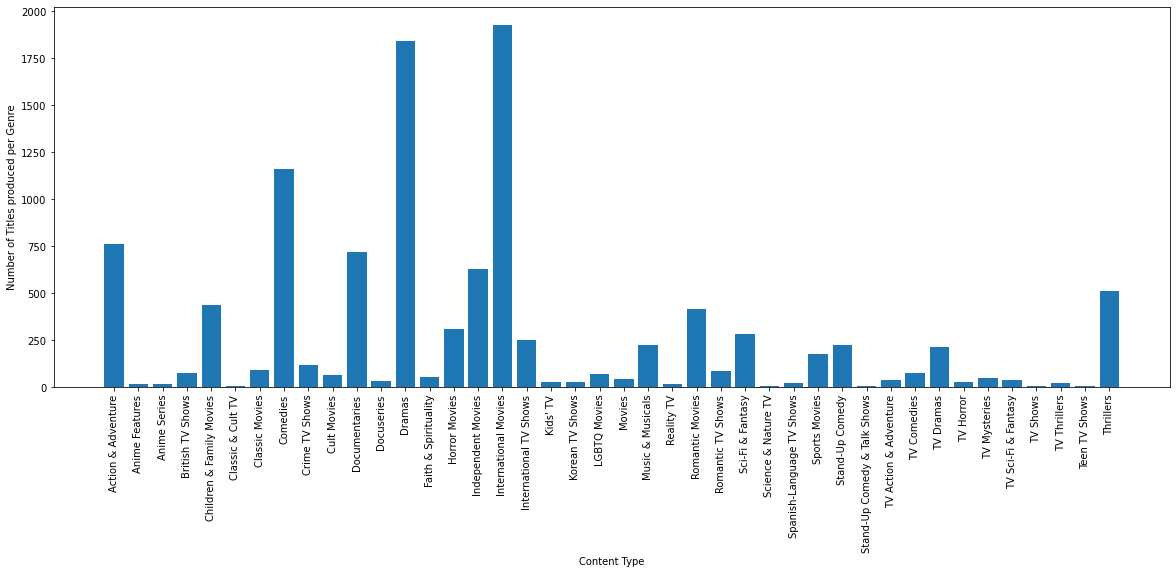

42


In [43]:
plt.figure(figsize=(20,7))
plt.ylabel("Number of Titles produced per Genre")
plt.xlabel("Content Type")
plt.xticks(rotation=90)
plt.bar(netflix_groupby_genre_countries.index, netflix_groupby_genre_countries['Country'])
plt.show()
print (len(netflix_groupby_genre_countries.index))

#hvplot -> groupby ="Countries"



In [44]:
net_flix.hvplot.bar(x='ListedIn', y='Genre', width=600, 
                         groupby='Country', rot = 90)


:DynamicMap   [Country]
   :Bars   [ListedIn]   (Genre)

## Top 10 content types

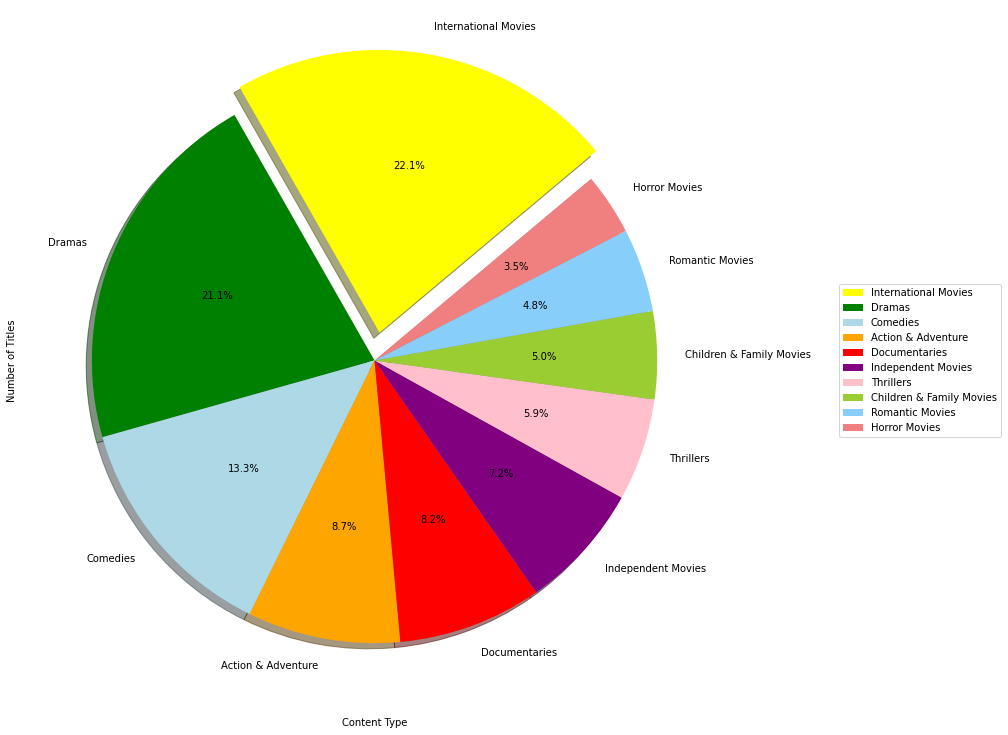

In [45]:
netflix_groupby_genre_countries_sorted = netflix_groupby_genre_countries.sort_values ('Country', ascending=False)
netflix_groupby_genre_countries_sorted_top10 = netflix_groupby_genre_countries_sorted.iloc[:10]

plt.figure(figsize=(13,13))
plt.ylabel("Number of Titles")
plt.xlabel("Content Type")
colors = ["yellow","green","lightblue","orange","red","purple","pink","yellowgreen","lightskyblue","lightcoral"]
explode = (0.1,0,0,0,0,0,0,0,0,0)
plt.pie(netflix_groupby_genre_countries_sorted_top10['Country'], explode=explode, colors=colors,autopct="%1.1f%%",
        labels=netflix_groupby_genre_countries_sorted_top10.index,shadow=True,startangle=40)
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))
plt.show()


In [46]:
### Top 20 tiltes based on the revenue 
netflix_directors_casts = netflix_titles_casts.merge (netflix_titles_directors, left_on='Titles',right_on='Titles')
netflix_titles_costs = netflix_titles.filter(['show_id','title','Budget','Revenue'], axis=1)

netflix_directors_casts_revenue = netflix_directors_casts.merge (netflix_titles_costs, left_on='Titles',right_on='show_id')
netflix_groupby_directors_casts_costs = netflix_directors_casts_revenue.groupby(['Cast','Director'])['Revenue'].max().reset_index()
#netflix_groupby_directors_casts.sort_values ('Titles', ascending=False)
TopPairDirectorCast = netflix_groupby_directors_casts_costs.sort_values(['Revenue'], ascending=False)
TopPairDirectorCast.head (10)

,Cast,Director,Revenue
4780,Chris Pratt,Anthony Russo,2046239637
22416,Scarlett Johansson,Anthony Russo,2046239637
2026,Anthony Mackie,Joe Russo,2046239637
2024,Anthony Mackie,Anthony Russo,2046239637
11270,Jeremy Renner,Anthony Russo,2046239637
21162,Robert Downey Jr.,Joe Russo,2046239637
21159,Robert Downey Jr.,Anthony Russo,2046239637
22553,Sebastian Stan,Anthony Russo,2046239637
22554,Sebastian Stan,Joe Russo,2046239637
11271,Jeremy Renner,Joe Russo,2046239637


## 	Is Netflix has increasingly focusing on TV rather than movies in recent years?

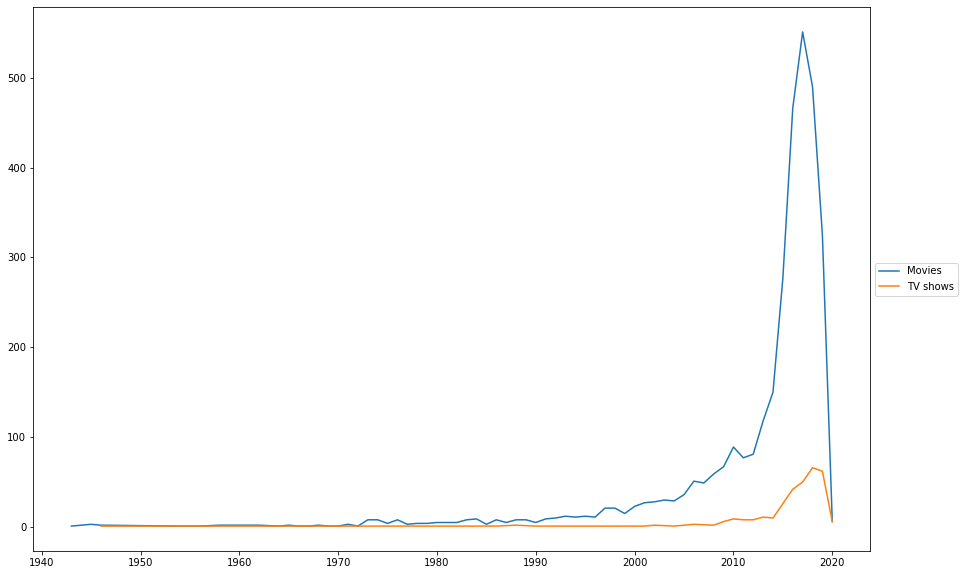

In [47]:
netflix_titles_rename_type = netflix_titles.rename(columns={'type':'show_type'})

netflix_titles_type_years = netflix_titles_rename_type.filter(['show_id','show_type','Netflix release year'], axis=1)

netflix_titles_type_years_movies = netflix_titles_type_years.loc[netflix_titles_type_years['show_type'] == 'Movie',:]
netflix_titles_type_years_tvshows = netflix_titles_type_years.loc[netflix_titles_type_years['show_type'] == 'TV Show',:]

netflix_titles_type_years_movies_groupby = netflix_titles_type_years_movies.groupby(['Netflix release year']).count()
netflix_titles_type_years_tvshows_groupby = netflix_titles_type_years_tvshows.groupby(['Netflix release year']).count()
plt.figure(figsize=(15,10))
plt.plot(netflix_titles_type_years_movies_groupby.index, netflix_titles_type_years_movies_groupby['show_id'], label='Movies')
plt.plot(netflix_titles_type_years_tvshows_groupby.index, netflix_titles_type_years_tvshows_groupby['show_id'], label='TV shows')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## After enriching the data with IMDB Rating and Revenue
* Rating vs Revenue

In [48]:
netflix_rating_revenue_2columns = netflix_titles.filter (['IMDB rating','Revenue'], axis=1)
netflix_rating_revenue_2columns_groupby = netflix_rating_revenue_2columns.groupby('IMDB rating').sum()
netflix_rating_revenue_2columns_groupby.sort_values (['Revenue'],inplace=True,ascending=False)
netflix_rating_revenue_2columns_groupby

,Revenue
IMDB rating,
6.0,31028019134
7.0,25359541546
8.0,14927315934
5.0,11026017815
4.0,1376049861
0.0,660714035
3.0,249541471
1.0,98441954
2.0,855450


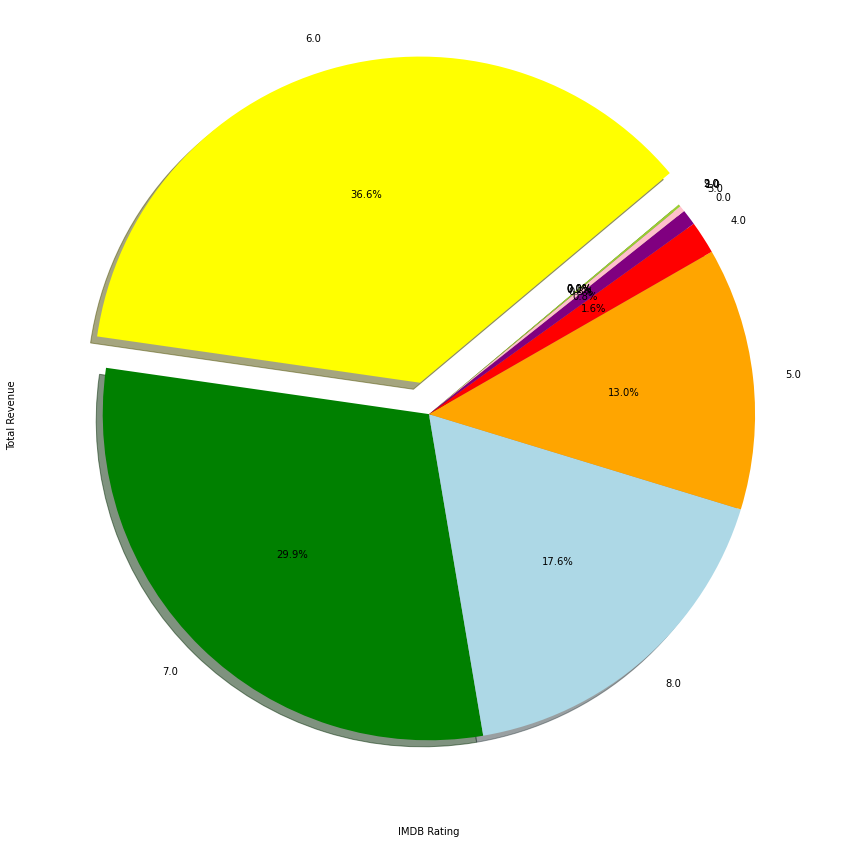

In [49]:
plt.figure(figsize=(15,15))
plt.ylabel("Total Revenue")
plt.xlabel("IMDB Rating")
colors = ["yellow","green","lightblue","orange","red","purple","pink","yellowgreen","lightskyblue","lightcoral"]
explode = (0.1,0,0,0,0,0,0,0,0,0)
plt.pie(netflix_rating_revenue_2columns_groupby['Revenue'], explode=explode, colors=colors, autopct="%1.1f%%",
        labels=netflix_rating_revenue_2columns_groupby.index,shadow=True,startangle=40)

plt.show()

* Genre vs revenue

In [50]:
netflix_genre_revenue = netflix_titles.merge (netflix_titles_listed_in, left_on='show_id',right_on='Titles')
netflix_genre_revenue_2columns = netflix_genre_revenue.filter (['ListedIn','Revenue'], axis=1)
netflix_genre_revenue_2columns_groupby = netflix_genre_revenue_2columns.groupby('ListedIn').sum()
netflix_genre_revenue_2columns_groupby.sort_values (['Revenue'],inplace=True,ascending=False)
netflix_genre_revenue_2columns_groupby_top10 = netflix_genre_revenue_2columns_groupby.iloc[:10]
netflix_genre_revenue_2columns_groupby_top10

,Revenue
ListedIn,
Action & Adventure,47372463617
Sci-Fi & Fantasy,31440122347
Comedies,29626132802
Dramas,22074089029
Children & Family Movies,20045110806
International Movies,11426213095
Thrillers,8234685357
Romantic Movies,6608774642
Horror Movies,5788648961


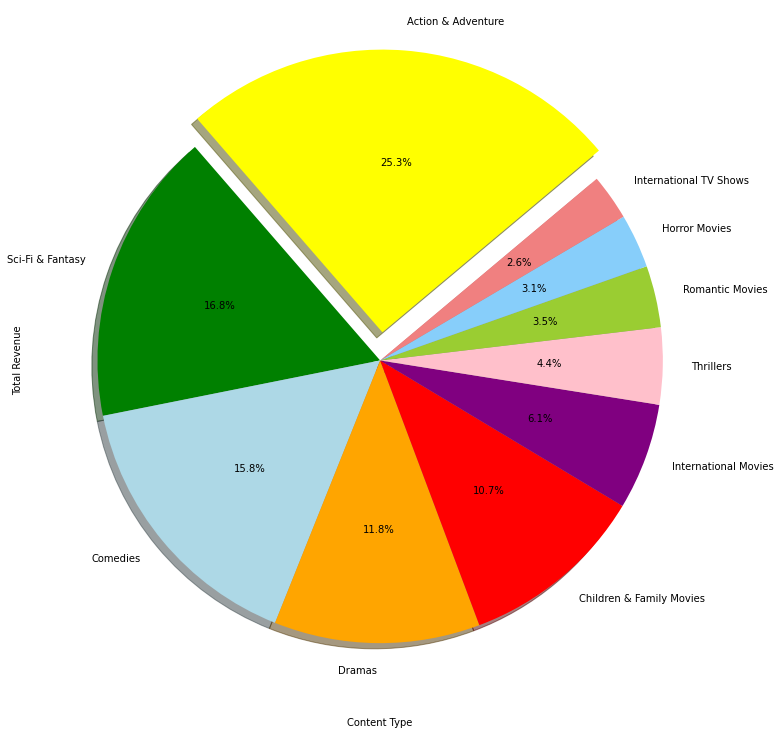

In [51]:
plt.figure(figsize=(13,13))
plt.ylabel("Total Revenue")
plt.xlabel("Content Type")
colors = ["yellow","green","lightblue","orange","red","purple","pink","yellowgreen","lightskyblue","lightcoral"]
explode = (0.1,0,0,0,0,0,0,0,0,0)
plt.pie(netflix_genre_revenue_2columns_groupby_top10['Revenue'], explode=explode, colors=colors, autopct="%1.1f%%",
        labels=netflix_genre_revenue_2columns_groupby_top10.index,shadow=True,startangle=40)

plt.show()